In [3]:
import pandas as pd
import anndata as ad
from loguru import logger 
import time

import numpy as np
import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

import shapely
import geopandas as gpd

import os
import sys
sys.path.append(os.path.abspath('../scripts'))
import utils
import importlib

import scimap as sm

Running SCIMAP  2.1.3


In [2]:
path_to_quant = "../data/quantification/990_backsub_quantification.csv"
path_to_geojson = "../data/geojsons/990.geojson"

In [4]:
adata = utils.read_quant(path_to_quant)

2024-09-17 12:03:35.361 | INFO     | utils:read_quant:21 -  ---- read_quant : version number 1.0.0 ----
/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

2024-09-17 12:03:37.700 | INFO     | utils:read_quant:40 -  386737 cells and 75 variables
2024-09-17 12:03:37.701 | INFO     | utils:read_quant:41 -  ---- read_quant is done, took 2s  ----


In [6]:
def filter_by_annotation(adata, path_to_geojson) -> ad.AnnData:
    """ Filter cells by annotation in a geojson file """

    gdf = gpd.read_file(path_to_geojson)

    #needed but will be deleted before returning adata
    adata.obs['point_geometry'] = adata.obs.apply(lambda cell: shapely.geometry.Point( cell['X_centroid'], cell['Y_centroid']), axis=1)

    def label_point_if_inside_polygon(point, polygons):
        for i, polygon in enumerate(polygons):
            if polygon.contains(point):
                return f"ann_{i+1}"
        return "not_found"
    
    adata.obs['ann'] = adata.obs['point_geometry'].apply(lambda cell: label_point_if_inside_polygon(cell, gdf.geometry))
    adata.obs['filter_by_ann'] = adata.obs['ann'] == "not_found"

    return adata

In [12]:
adata = filter_by_annotation(adata, path_to_geojson)

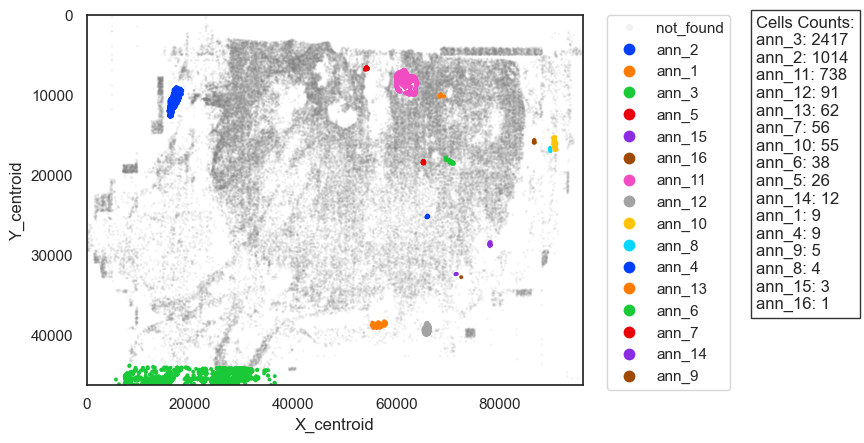

In [13]:
#plotting
labels_to_plot = list(adata.obs['ann'].unique())
labels_to_plot.remove("not_found")
max_x, max_y = adata.obs[['X_centroid', 'Y_centroid']].max()

tmp_df_ann = adata.obs[adata.obs['ann'].isin(labels_to_plot)]
tmp_df_Keep = adata.obs[adata.obs['ann']=="not_found"].sample(frac=0.2, random_state=0).reset_index(drop=True)

sns.scatterplot(data=tmp_df_Keep, x='X_centroid', y='Y_centroid', hue='ann', palette='grey', linewidth=0, s=3, alpha=0.1)
sns.scatterplot(data=tmp_df_ann, x='X_centroid', y='Y_centroid', hue='ann', palette='bright', linewidth=0, s=8)

plt.xlim(0, max_x)
plt.ylim(max_y, 0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=3)

# Show value counts
value_counts = tmp_df_ann['ann'].value_counts()
value_counts_str = "\n".join([f"{cat}: {count}" for cat, count in value_counts.items()])

plt.gca().text(1.35, 1, f"Cells Counts:\n{value_counts_str}",
        transform=plt.gca().transAxes, 
        fontsize=12, 
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.show()

In [15]:
adata.obs.dtypes

CellID               int64
Y_centroid         float64
X_centroid         float64
Area               float64
MajorAxisLength    float64
MinorAxisLength    float64
Eccentricity       float64
Orientation        float64
Extent             float64
Solidity           float64
point_geometry      object
ann                 object
filter_by_ann         bool
dtype: object

In [16]:
adata.obs = adata.obs.drop(columns=['point_geometry', 'ann'])

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,filter_by_ann
0,0,19615.485729,84002.783175,1997.0,69.650764,39.550397,0.823140,1.497353,191.681241,0.893912,True
1,1,19632.750545,84207.927101,4129.0,84.506589,62.393000,0.674449,-0.537030,241.036580,0.987327,True
2,2,19857.564702,83551.500678,5904.0,103.613658,74.142701,0.698542,0.650811,300.735065,0.972652,True
3,3,20564.099932,87761.815041,2952.0,67.044385,56.220064,0.544825,0.066121,205.580736,0.977160,True
4,4,9987.932615,43232.524259,742.0,34.001316,28.077692,0.563989,-0.804180,101.639610,0.968668,True
...,...,...,...,...,...,...,...,...,...,...,...
386732,386732,6740.910891,40549.411881,1010.0,38.551393,34.098898,0.466531,-0.246833,121.438600,0.963740,True
386733,386733,6741.301832,41021.183221,1037.0,40.331096,32.806114,0.581677,0.512383,119.053824,0.976460,True
386734,386734,6748.297222,43045.971296,1080.0,44.270566,32.625733,0.675934,0.317822,134.166522,0.926244,True
386735,386735,6736.697105,39354.403118,898.0,48.917902,24.408819,0.866616,1.262229,126.710678,0.955319,True


In [21]:
def filter_by_annotation(adata, path_to_geojson) -> ad.AnnData:
    """ Filter cells by annotation in a geojson file """
    logger.info(" ---- filter_by_annotation : version number 1.1.0 ----")
    time_start = time.time()
    
    gdf = gpd.read_file(path_to_geojson)
    assert gdf.geometry is not None, "No geometry found in the geojson file"
    assert gdf.geometry.type.unique()[0] == 'Polygon', "Only polygon geometries are supported"
    logger.info(f"GeoJson loaded, detected: {len(gdf)} annotations")

    adata.obs['point_geometry'] = adata.obs.apply(lambda cell: shapely.geometry.Point( cell['X_centroid'], cell['Y_centroid']), axis=1)
    
    def label_point_if_inside_polygon(point, polygons):
        for i, polygon in enumerate(polygons):
            if polygon.contains(point):
                return f"ann_{i+1}"
        return "not_found"
    
    adata.obs['ann'] = adata.obs['point_geometry'].apply(lambda cell: label_point_if_inside_polygon(cell, gdf.geometry))
    adata.obs['filter_by_ann'] = adata.obs['ann'] == "not_found"
    logger.info("Labelled cells with annotations if they were found inside")

    #plotting
    labels_to_plot = list(adata.obs['ann'].unique())
    labels_to_plot.remove("not_found")
    max_x, max_y = adata.obs[['X_centroid', 'Y_centroid']].max()

    tmp_df_ann = adata.obs[adata.obs['ann'].isin(labels_to_plot)]
    tmp_df_Keep = adata.obs[adata.obs['ann']=="not_found"].sample(frac=0.2, random_state=0).reset_index(drop=True)

    sns.scatterplot(data=tmp_df_Keep, x='X_centroid', y='Y_centroid', hue='ann', palette='grey', linewidth=0, s=3, alpha=0.1)
    sns.scatterplot(data=tmp_df_ann, x='X_centroid', y='Y_centroid', hue='ann', palette='bright', linewidth=0, s=8)

    plt.xlim(0, max_x)
    plt.ylim(max_y, 0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=3)

    # Show value counts
    value_counts = tmp_df_ann['ann'].value_counts()
    value_counts_str = "\n".join([f"{cat}: {count}" for cat, count in value_counts.items()])

    plt.gca().text(1.35, 1, f"Cells Counts:\n{value_counts_str}",
            transform=plt.gca().transAxes, 
            fontsize=12, 
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

    #drop object columns ( this would block saving to h5ad)
    adata.obs = adata.obs.drop(columns=['point_geometry', 'ann'])

    logger.info(f" ---- filter_by_annotation is done, took {int(time.time() - time_start)}s  ----")
    return adata

2024-09-17 13:03:03.536 | INFO     | utils:read_quant:21 -  ---- read_quant : version number 1.0.0 ----
/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

2024-09-17 13:03:05.510 | INFO     | utils:read_quant:40 -  386737 cells and 75 variables
2024-09-17 13:03:05.511 | INFO     | utils:read_quant:41 -  ---- read_quant is done, took 1s  ----
2024-09-17 13:03:05.518 | INFO     | __main__:filter_by_annotation:3 -  ---- filter_by_annotation : version number 1.1.0 ----
2024-09-17 13:03:05.528 | INFO     | __main__:filter_by_annotation:9 - GeoJson loaded, detected: 16 annotations
2024-09-17 13:03:39.846 | INFO     | __main__:filter_by_annotation:21 - Labelled cells with annotations if they were found inside


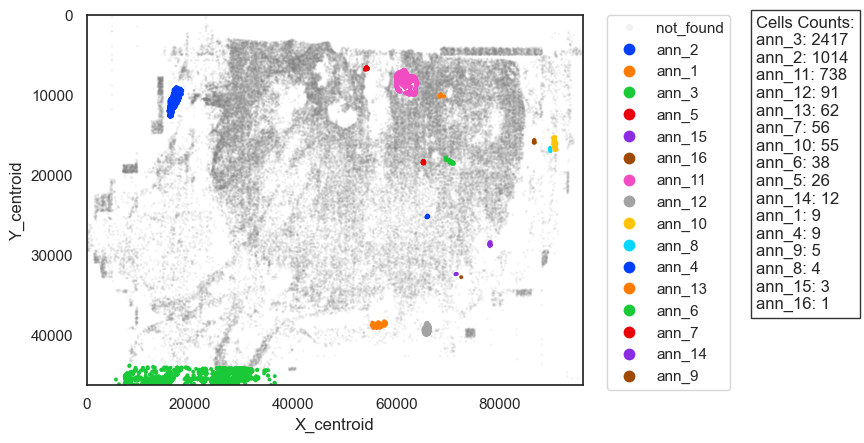

2024-09-17 13:03:40.359 | INFO     | __main__:filter_by_annotation:53 -  ---- filter_by_annotation is done, took 34s  ----


In [22]:
adata = utils.read_quant(path_to_quant)
adata = filter_by_annotation(adata, path_to_geojson)

In [24]:
adata.write_h5ad("../data/filtered.h5ad")